# 0. Basics

## 0.0. Imports

In [1]:
import primod
import imod
from imod import msw
from imod import mf6

In [2]:
import importlib.metadata as md, json, pathlib, imod, primod
from imod.mf6 import GroundwaterFlowModel as GWF

print("imod:", md.version("imod"))
print("primod path:", primod.__file__)
du = next(p for p in md.distribution("primod").files if p.name=="direct_url.json")
print("primod commit:", json.loads(pathlib.Path(md.distribution("primod").locate_file(du)).read_text())["vcs_info"]["commit_id"])
print("has get_diskey:", hasattr(GWF, "get_diskey"))

imod: 1.0.0rc7
primod path: g:\.pixi\envs\default\Lib\site-packages\primod\__init__.py
primod commit: f2628433d07087f867c36219dbbe1c86f9778bbb
has get_diskey: True


In [3]:
import importlib as IL
IL.reload(primod)
IL.reload(imod)

<module 'imod' from 'g:\\.pixi\\envs\\default\\Lib\\site-packages\\imod\\__init__.py'>

In [4]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [5]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G
from WS_Mdl.utils import bold, style_reset

In [48]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'G:\\code\\WS_Mdl\\geo.py'>

In [7]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import LineString, MultiLineString, box
from shapely.ops import linemerge

In [8]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [9]:
import DRN_SFR_match
from DRN_SFR_match import match_cells_to_SFR
import w_MVR
from w_MVR import w_MVR

## 0.1. Options

In [10]:
Pa_Gpkg = PJ(U.Pa_WS, r"g:\models\NBr\PrP\SFR\BrabantseDelta\Gpkg\WBD_detail_SW_NW_cleaned.gpkg")

In [11]:
MdlN = 'NBr37'

In [12]:
U.set_verbose(False)

In [13]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

In [14]:
U.Mdl_Dmns_from_INI(d_Pa['INI'])

(113100.0, 387600.0, 125100.0, 396200.0, 25.0, 344, 480)

In [15]:
l_X_Y_Cols = ['Xstart', 'Ystart', 'Xend', 'Yend']

# 1. Load Model Ins

## 1.0. Load PRJ

In [16]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [17]:
PRJ, period_data = PRJ_[0], PRJ_[1]

## 1.1. Load DIS and limit to Mdl Aa

In [18]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [19]:
BND = PRJ_regrid['bnd']['ibound']

In [20]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


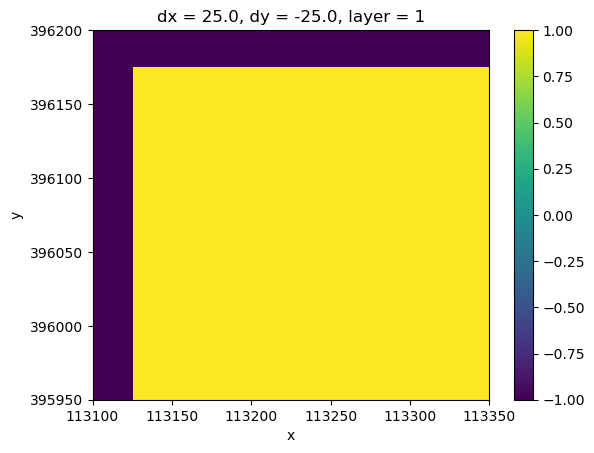

In [21]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

## 1.2. Load MF6 Mdl

In [22]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [23]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

In [24]:
MF6_Mdl = Sim_MF6['imported_model']

In [25]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

In [26]:
MF6_DIS = MF6_Mdl["dis"]  # This gets the OLD 100m grid

## 1.3. Load MSW

### 1.3.0. Fix mete_grid.inp relative paths

In [27]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ_regrid)

Created corrected mete_grid.inp: G:\models\NBr\In\CAP\mete_grid\NBr1\temp\mete_grid.inp


### 1.3.2. Finally load MSW Sim

In [28]:
# Create the MetaSwap model
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🟢 - MetaSwap model loaded successfully!")

🟢 - MetaSwap model loaded successfully!


## 1.4. Connect MF6 to MetaSWAP

### 1.4.1. Clip models

In [29]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [30]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [31]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


## 1.5. Load & Cleanup models

### 1.5.0. Load

In [32]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

### 1.5.1. MF6 mask

In [33]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [34]:
# Fix CHD package layer ordering issue (layers must be monotonically increasing)
from imod.mf6 import ConstantHead
chd_pkg = Sim_MF6_AoI['imported_model']['chd_merged']
head_data_sorted = chd_pkg.dataset['head'].load().sortby('layer')
Sim_MF6_AoI['imported_model']['chd_merged'] = ConstantHead(head=head_data_sorted, validate=False)

In [35]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### 1.5.2. Cleanup MF6

In [36]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packages. Proceeding without cleanup. Fingers crossed!')

### 1.5.3 Cleanup MetaSWAP

In [37]:
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## 1.6. Couple & Write

In [38]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [39]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [40]:
# Use correct paths from d_Pa instead of hardcoded paths
Pa_MF6_DLL = d_Pa['MF6_DLL']
Pa_MSW_DLL = d_Pa['MSW_DLL']
Pa_IMC = d_Pa['coupler_Exe']

print(f"✅ MF6 DLL path: {Pa_MF6_DLL}")
print(f"✅ MSW DLL path: {Pa_MSW_DLL}")
print(f"✅ Coupler exe path: {d_Pa['coupler_Exe']}")

✅ MF6 DLL path: G:/software/iMOD5/IMC_2024.4\./modflow6/libmf6.dll
✅ MSW DLL path: G:/software/iMOD5/IMC_2024.4\./metaswap/MetaSWAP.dll
✅ Coupler exe path: G:/software/iMOD5/IMC_2024.4/imodc.exe


In [41]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

g:\.pixi\envs\default\Lib\site-packages\imod\mf6\model.py:211: DeprecationWarning: Method '_get_diskey' is deprecated, use 'get_diskey' instead.
  warnings.warn(
g:\.pixi\envs\default\Lib\site-packages\imod\msw\model.py:265: DeprecationWarning: Method '_get_pkg_key' is deprecated, use 'get_pkgkey' instead.
  warnings.warn(
g:\.pixi\envs\default\Lib\site-packages\imod\mf6\model.py:211: DeprecationWarning: Method '_get_diskey' is deprecated, use 'get_diskey' instead.
  warnings.warn(


# 2. Create SFR lines

## 2.1.Load

In [319]:
GDF = gpd.read_file(Pa_Gpkg)

In [320]:
GDF0 = GDF.copy()

In [321]:
GDF = U.GDF_clip_Mdl_Aa(GDF, d_Pa['INI'])

🟢 - GeoDataFrame limited to model area from G:/models/NBr\code/Mdl_Prep/Mdl_Prep_NBr37.ini. Original rows: 3514, Limited rows: 3514.


In [322]:
GDF1 = GDF.copy()

In [345]:
GDF1.shape

(3514, 14)

In [323]:
GDF1.describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


## 2.2 Ensure slope

#### Upstream and downstream elevations

In [324]:
GDF[[ 'ID', 'Elv_UStr', 'Elv_DStr']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS.

In [325]:
(GDF['Elv_UStr'] <= GDF['Elv_DStr']).sum(), (GDF['Elv_UStr'] < GDF['Elv_DStr']).sum(), (GDF['Elv_UStr'] > GDF['Elv_DStr']).sum(), GDF.shape[0]

(np.int64(1020), np.int64(610), np.int64(2494), 3514)

We will assume SFRmaker will work where Elv_UStr >= Elv_DStr, so we'll only adjust those where Elv_UStr < Elv_DStr.

#### Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)*

In [326]:
GDF_Elv = GDF[['ID', 'Elv_UStr', 'Elv_DStr', 'DStr_code', 'DStr_ID']].copy()

In [327]:
GDF_Elv['Diff'] = GDF_Elv['Elv_UStr'] - GDF_Elv['Elv_DStr']

In [328]:
GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [329]:
GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='Diff', ascending=True).head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)*

In [330]:
l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'ID'].tolist()
for S in l_problematic:
    sum = (GDF['DStr_code']==S).sum()
    if sum > 1:
        print(S, sum)

##### Elv correction algorithm

We'll design an algorithm to fix those with <. Those with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1.

In [331]:
GDF_Elv = GDF_Elv.merge(GDF[['ID', 'Elv_UStr', 'Elv_DStr']], left_on='DStr_ID', right_on='ID', suffixes=('', '_DStr'), how='left')

In [332]:
GDF_Elv[['A', 'B']] = GDF_Elv[['Elv_UStr', 'Elv_DStr']].copy()

In [333]:
GDF_Elv[['C', 'D']] = GDF_Elv[['Elv_UStr', 'Elv_DStr']].copy()

In [334]:
GDF_Elv[GDF_Elv['B'].isna()]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [335]:
def adjust_elevations(row):
    if row['C'] <= row['D']: # If UStr Elv <= DStr Elv, no adjustment needed
        return row['B'], row['C']
    elif (row['C'] > row['D']) and (pd.isna(row['B'])): # If UStr Elv <= DStr Elv but DStr Elv is missing (OuFl segment), set both to DStr Elv
        return pd.NA, row['D']
    elif (row['C'] > row['D']) and (row['B'] <= row['D']):
        return row['B'], row['D']
    elif (row['C'] > row['D']) and (row['B'] > row['D']):
        return row['D'], row['D']
    else:
        # Default case - should not happen, but ensures function always returns a tuple
        return row['B'], row['C']

In [336]:
GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

I'm worried consequtive segments might be problematic. Let's check if there are any.

In [337]:
GDF_Elv_unfixed = GDF_Elv[ (GDF_Elv['Diff']<0)]
consequtive = GDF_Elv_unfixed.loc[GDF_Elv_unfixed['DStr_ID'].isin(GDF_Elv_unfixed['ID']), 'DStr_ID']
GDF_Elv_unfixed.loc[ (GDF_Elv_unfixed['ID'].isin(consequtive)) | (GDF_Elv_unfixed['DStr_ID'].isin(consequtive)), ['ID', 'DStr_ID', 'A', 'B', 'B_', 'C', 'C_', 'D']].sort_values(by='D').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Consequtive ok. Let's check if there is a drop in Elv (positive slope) for each segment.

In [338]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['C_'] < 0 ]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Cool, no segments without any drop in Elv.

In [339]:
GDF_Elv['segment_drop'] = GDF_Elv['D'] - GDF_Elv['C_']
GDF_Elv['DStr_drop'] = GDF_Elv['C_'] - GDF_Elv['B']
GDF_Elv.loc[ GDF_Elv['C_'] - GDF_Elv['B_'] < 0 , ['ID', 'DStr_ID', 'A', 'B', 'B_', 'C', 'C_', 'D', 'segment_drop', 'DStr_drop'] ].sort_values(by='DStr_drop').reset_index(drop=True) 

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


There are **quite a few** segments where C_ > B!!! SFRmaker might fix this. If not, I'll come back and fix it.

In [340]:
GDF2 = GDF.copy()

In [341]:
GDF

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [342]:
GDF = GDF.merge( GDF_Elv[['ID', 'C_', 'D']], on='ID', how='left')

## 2.3 Remove DStr_IDs that are outside the model

In [350]:
GDF3 = GDF.copy()

In [351]:
GDF_DStr_Out_Mdl_Aa = GDF.loc[~GDF['DStr_ID'].isin(GDF['ID']) & GDF['DStr_ID']!=0]
GDF_DStr_Out_Mdl_Aa

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [352]:
len(GDF_DStr_Out_Mdl_Aa), GDF_DStr_Out_Mdl_Aa['DStr_ID'].nunique()

(23, 16)

In [353]:
GDF.loc[~GDF['DStr_ID'].isin(GDF['ID']) & GDF['DStr_ID']!=0, 'DStr_ID'] = 0

In [354]:
len(GDF.loc[~GDF['DStr_ID'].isin(GDF['ID']) & GDF['DStr_ID']!=0, 'DStr_ID'])

0

## 2.5 Generate SFRmaker lines

In [355]:
GDF.columns

Index(['ID', 'DStr_ID', 'width', 'length', 'Elv_UStr', 'Elv_DStr', 'Xa', 'Ya',
       'Xz', 'Yz', 'CODE', 'DStr_code', 'split', 'geometry', 'C_', 'D',
       'width2'],
      dtype='object')

In [356]:
GDF['width2'] = GDF['width'].copy()

In [357]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='ID',
    routing_column='DStr_ID',
    width1_column='width', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [358]:
DF_lines = lines.df
U.DF_info(lines.df)

Lines dataframe info:
Shape: (3514, 10)
Data types:
id            object
toid          object
asum1          int64
asum2          int64
width1       float64
width2       float64
elevup       float64
elevdn       float64
name          object
geometry    geometry
dtype: object

Basic statistics for numeric columns:


In [359]:
DF_lines.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


# 3. Connect SFR to MF6 model

## 3.0. Create SFR_grid item

### 3.0.0 Initiate parameters

In [360]:
# Create sfr.StructuredGrid directly from MF6_DIS (DataFrame approach) #666 This cell and the cells below it can be combined into a function to read in a MF6_DIS (imod) object, and return a DF (GDF_grid) with the grid and geometry. 
DS = MF6_DIS.dataset
N_L, N_R, N_C = DS.dims['layer'], DS.dims['y'], DS.dims['x']
dx, dy = abs(float(DS.coords['dx'].values)), abs(float(DS.coords['dy'].values))
Ls, Xs, Ys = DS.coords['layer'].values, DS.coords['x'].values, DS.coords['y'].values
X_Ogn, Y_Ogn = Xs[0] - dx/2, Ys[0] + dy/2  # Upper-left corner

In [361]:
# Construct TOP, BOT. TOP array: 1st layer from DS['top'], rest from DS['bottom'][::-1] with layer+1
TOPs = np.zeros((N_L, N_R, N_C))
TOPs[0] = DS['top'].values
TOPs[1:] = DS['bottom'].sel(layer=range(1, N_L))
BOTs = DS['bottom'].values  # Shape: (N_L, N_R, N_C)

In [362]:
# Create full 3D grid indices
k, i, j = np.meshgrid(range(N_L), range(N_R), range(N_C), indexing='ij')
k, i, j = k.ravel(), i.ravel(), j.ravel()

### 3.0.1 Prepare GDF

In [363]:
GDF_grid = gpd.GeoDataFrame({
    'k': k,
    'i': i,
    'j': j, 
    'node': range(N_L * N_R * N_C),
    'isfr': 1,  # All cells can potentially have SFR # if function is made out of this, this needs to be removed and added to the DF after the function has run.
    'top': TOPs.ravel(),
    'bottom': BOTs.ravel(),
})

In [364]:
mask = GDF_grid['k'].eq(0)
i_L0 = GDF_grid.loc[mask, 'i'].to_numpy()
j_L0 = GDF_grid.loc[mask, 'j'].to_numpy()

In [365]:
xmin = X_Ogn + j_L0*dx
xmax = X_Ogn + (j_L0+1)*dx
ymin = Y_Ogn - (i_L0+1)*dy
ymax = Y_Ogn - i_L0*dy

In [366]:
L0_geom = [box(x0, y0, x1, y1) for x0, y0, x1, y1 in zip(xmin, ymin, xmax, ymax)]

In [367]:
for k in GDF_grid['k'].unique():
    GDF_grid.loc[GDF_grid['k'] == k, 'geometry'] = L0_geom

In [368]:
GDF_grid = GDF_grid.set_geometry('geometry', crs=DS.rio.crs)

### 3.0.2 Identify deepest SFR layer

The reason we're doing this is that the model has too many Ls and it takes a very long time to run the SFR functions with all of them. So we'll find the deepest L that has any part of the stream network in it, and **we'll only use up to that layer for the SFR grid.**

In [369]:
for L in range(BOTs.shape[0]):
    L_BOT_min = BOTs[L].min()
    L_BOT_max = BOTs[L].max()
    print(L+1, f"|{L_BOT_min:8.2f} |", f"{L_BOT_max:8.2f} |")
    if L_BOT_min > DF_lines['elevdn'].min():
        SFR_deepest_L = L+1

1 |   -0.07 |    26.03 |
2 |   -0.57 |    26.03 |
3 |   -0.69 |    25.29 |
4 |   -0.70 |    25.28 |
5 |   -1.61 |    23.12 |
6 |   -1.62 |    23.11 |
7 |   -2.45 |    22.68 |
8 |   -2.45 |    22.68 |
9 |   -7.97 |    20.45 |
10 |   -7.98 |    18.94 |
11 |  -11.80 |    14.77 |
12 |  -11.80 |    14.77 |
13 |  -12.58 |    12.95 |
14 |  -12.58 |    12.95 |
15 |  -15.40 |    12.95 |
16 |  -16.97 |     4.91 |
17 |  -32.06 |    -0.27 |
18 |  -38.87 |    -7.12 |
19 |  -69.23 |   -17.66 |
20 |  -69.23 |   -17.66 |
21 |  -70.36 |   -20.17 |
22 |  -70.36 |   -23.86 |
23 |  -71.30 |   -34.08 |
24 |  -71.30 |   -34.08 |
25 |  -87.47 |   -38.37 |
26 |  -87.48 |   -38.38 |
27 |  -87.48 |   -38.38 |
28 |  -87.48 |   -38.38 |
29 |  -87.48 |   -38.38 |
30 |  -87.52 |   -38.42 |
31 |  -87.52 |   -38.42 |
32 |  -87.52 |   -38.42 |
33 |  -87.52 |   -38.42 |
34 |  -98.77 |   -41.37 |
35 | -185.43 |   -69.26 |
36 | -185.43 |   -69.26 |
37 | -423.19 |  -191.40 |


In [370]:
SFR_deepest_L

6

### 3.0.3 Create SFR grid(s)

In [371]:
SFR_grid = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] <= SFR_deepest_L-1], crs=G.crs) # -1 cause grid k starts at 0, L at 1

In [372]:
SFR_grid_L1 = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] == 0], crs=G.crs) # Extract layer 1 (k=0)

In [373]:
# Check what type of object and its basic info without triggering full repr
print(f"Type: {type(SFR_grid)}")
print(f"SFR_grid object created: {SFR_grid is not None}")

# Check if it has expensive methods for representation
print(f"Available methods: {[method for method in dir(SFR_grid) if not method.startswith('_')][:10]}")

# Try to get basic info without full representation
try:
    print(f"Grid shape info: {hasattr(SFR_grid, 'shape')}")
    if hasattr(SFR_grid, 'nlay'):
        print(f"Number of layers: {SFR_grid.nlay}")
    if hasattr(SFR_grid, 'nrow'):
        print(f"Number of rows: {SFR_grid.nrow}")
    if hasattr(SFR_grid, 'ncol'):
        print(f"Number of cols: {SFR_grid.ncol}")
except Exception as e:
    print(f"Error getting basic info: {e}")

Type: <class 'sfrmaker.grid.StructuredGrid'>
SFR_grid object created: True
Available methods: ['active_area', 'bounds', 'create_active_area_polygon_from_isfr', 'crs', 'df', 'dx', 'dy', 'from_dataframe', 'from_json', 'from_modelgrid']
Grid shape info: False
Number of layers: 6
Number of rows: 344
Number of cols: 480


## 3.2. SFRdata

### 3.2.0 Create

In [432]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='ID',
    routing_column='DStr_ID',
    width1_column='width', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [433]:
DF_L = lines.df

In [436]:
lines.df.shape

(3514, 10)

In [434]:
lines.df.describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [ ]:
DF_L.loc[ ~DF_L['toid'].isin(DF_L['id']) & (DF_L['toid']!='0')]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [437]:
DF_L.shape

(3514, 10)

In [439]:
DF_L.loc[ ~DF_L['toid'].isin(DF_L['id']) & (DF_L['toid']!='0'), 'toid'] = '0' #666 Those are causing problems to lines.to_sfr cause they're not in the Mdl Aa

In [442]:
lines.df = DF_L.copy()

In [444]:
SFR_data = lines.to_sfr(grid=SFR_grid_L1)#, one_reach_per_cell=True,)


SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 3,513
remaining lines: 3,513
finished in 0.09s


Intersecting 3,513 flowlines with 165,120 grid cells...

Intersecting 3513 features...
916
Intersecting 3513 features...
3513
finished in 0.72s

Setting up reach data... (may take a few minutes for large grids)
3513
finished in 0.72s

Setting up reach data... (may take a few minutes for large grids)
finished in 3.21s

finished in 3.21s


Dropping 1103 reaches with length < 1.25 undefined...

Repairing routing connections...

Dropping 1103 reaches with length < 1.25 undefined...

Repairing routing connections...
enforcing best segment numbering...
enforcing best segment numbering...


KeyError: 35

In [427]:
# Let's check what exactly was fixed and verify the current state
print("Current lines.df shape:", lines.df.shape)
print("DF_L shape:", DF_L.shape)

# Check if they're the same object
print("lines.df is DF_L:", lines.df is DF_L)

# Check current routing problems
ids_current = set(lines.df['id'])
toids_current = set(lines.df['toid']) - {0}

missing_current = toids_current - ids_current
print("Current missing targets:", len(missing_current))
if len(missing_current) > 0 and len(missing_current) <= 10:
    print("Missing targets:", sorted(missing_current))

# Let's also check data types to make sure there's no type mismatch
print("\nData types in lines.df:")
print("id dtype:", lines.df['id'].dtype)
print("toid dtype:", lines.df['toid'].dtype)

Current lines.df shape: (3513, 10)
DF_L shape: (3514, 10)
lines.df is DF_L: False
Current missing targets: 0

Data types in lines.df:
id dtype: object
toid dtype: object


In [428]:
# Create a new Lines object with the corrected DF_L data
print("Creating new Lines object with corrected DF_L...")
lines_corrected = sfr.Lines(DF_L.copy())

print("New lines object shape:", lines_corrected.df.shape)
print("Check routing in corrected lines:")

ids_corrected = set(lines_corrected.df['id'])
toids_corrected = set(lines_corrected.df['toid']) - {0}
missing_corrected = toids_corrected - ids_corrected

print("Missing targets in corrected:", len(missing_corrected))
if len(missing_corrected) > 0:
    print("Remaining missing targets:", sorted(missing_corrected))

# Replace the lines object
lines = lines_corrected
print("✓ Lines object has been replaced with corrected version!")

Creating new Lines object with corrected DF_L...
New lines object shape: (3514, 10)
Check routing in corrected lines:
Missing targets in corrected: 1
Remaining missing targets: ['0']
✓ Lines object has been replaced with corrected version!


In [430]:
# Fix the mixed data types in toid column
print("Fixing mixed data types in toid column...")
DF_L_fixed = DF_L.copy()

# Check current data types and values
print("toid column dtype:", DF_L_fixed['toid'].dtype)
print("Sample toid values:", DF_L_fixed['toid'].head(10).tolist())

# Convert all toid values to integers, handling string '0'
def convert_toid(x):
    if x == '0' or x == 0:
        return 0
    try:
        return int(x)
    except:
        return 0

DF_L_fixed['toid'] = DF_L_fixed['toid'].apply(convert_toid)
DF_L_fixed['id'] = DF_L_fixed['id'].astype(int)

print("After conversion - toid dtype:", DF_L_fixed['toid'].dtype)
print("After conversion - id dtype:", DF_L_fixed['id'].dtype)

# Create new Lines object with properly fixed data
lines_final = sfr.Lines(DF_L_fixed)

# Verify fix
ids_final = set(lines_final.df['id'])
toids_final = set(lines_final.df['toid']) - {0}
missing_final = toids_final - ids_final

print("Final check - missing targets:", len(missing_final))
if len(missing_final) == 0:
    print("✓ All routing issues fixed!")
    lines = lines_final
    print("lines object updated successfully!")
else:
    print("Still have issues:", missing_final)

Fixing mixed data types in toid column...
toid column dtype: object
Sample toid values: ['54688', '58106', '58110', '5346', '0', '20682', '1762', '1762', '44755', '0']
After conversion - toid dtype: int64
After conversion - id dtype: int64
Final check - missing targets: 0
✓ All routing issues fixed!
lines object updated successfully!


In [445]:
# Try with absolutely minimal parameters to bypass as much processing as possible
try:
    print("Attempting minimal SFR creation...")
    SFR_minimal = lines.to_sfr(
        grid=SFR_grid_L1,
        minimum_reach_length=0.1,  # Very small to avoid dropping reaches
        add_outlets=False,         # Skip outlet processing
        consolidate_conductance=False  # Skip conductance consolidation
    )
    print("✓ SUCCESS! Minimal SFR creation worked!")
    print("Reach data shape:", SFR_minimal.reach_data.shape)
    SFR_data = SFR_minimal
    print("SFR_data assigned!")
    
except Exception as e:
    print("Even minimal approach failed:", str(e))
    print("This confirms it's a deeper bug in sfrmaker 0.12.1")
    print("\nRecommendation: Use a different version of sfrmaker or")
    print("contact the sfrmaker developers about this KeyError issue")

Attempting minimal SFR creation...

SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 3,513
remaining lines: 3,513
finished in 0.08s


Intersecting 3,513 flowlines with 165,120 grid cells...

Intersecting 3513 features...
3513
finished in 0.61s

Setting up reach data... (may take a few minutes for large grids)
finished in 2.89s


Dropping 105 reaches with length < 0.10 undefined...

Repairing routing connections...
Even minimal approach failed: 'NoneType' object has no attribute 'keys'
This confirms it's a deeper bug in sfrmaker 0.12.1

Recommendation: Use a different version of sfrmaker or
contact the sfrmaker developers about this KeyError issue


In [ ]:
# After installing a different sfrmaker version, you need to:
# 1. Restart the kernel OR
# 2. Use importlib to reload the module

import importlib
import sys

# Option 1: Remove the module from cache and reimport
if 'sfrmaker' in sys.modules:
    del sys.modules['sfrmaker']

# Option 2: Reload all sfrmaker submodules
modules_to_reload = [name for name in sys.modules if name.startswith('sfrmaker')]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

# Now reimport
import sfrmaker as sfr

print("sfrmaker reloaded successfully")
print("New version:", sfr.__version__)

In [ ]:
lines

In [416]:
'813' in lines.df['toid'].values

False

In [395]:
lines.df[lines.df['toid']==813]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [390]:
# Debug: Check if GDF has the right columns and types
print("GDF shape:", GDF.shape)
print("\nGDF columns:", GDF.columns.tolist())
print("\nColumn types:")
print(GDF.dtypes)
print("\nSample of first few rows:")
print(GDF[['ID', 'DStr_ID', 'width', 'width2', 'C_', 'D', 'CODE']].head())
print("\nAny NaN values in key columns?")
print(GDF[['ID', 'DStr_ID', 'width', 'width2', 'C_', 'D', 'CODE']].isna().sum())

GDF shape: (3514, 17)

GDF columns: ['ID', 'DStr_ID', 'width', 'length', 'Elv_UStr', 'Elv_DStr', 'Xa', 'Ya', 'Xz', 'Yz', 'CODE', 'DStr_code', 'split', 'geometry', 'C_', 'D', 'width2']

Column types:
ID              int64
DStr_ID         int64
width         float64
length        float64
Elv_UStr      float64
Elv_DStr      float64
Xa            float64
Ya            float64
Xz            float64
Yz            float64
CODE           object
DStr_code      object
split           int64
geometry     geometry
C_            float64
D             float64
width2        float64
dtype: object

Sample of first few rows:
     ID  DStr_ID  width  width2         C_          D      CODE
0   968    54688    1.0     1.0  11.795000  12.014999  OWL55578
1  1572    58106    1.0     1.0   5.345000   5.385000  OWL31118
2  1573    58110    1.0     1.0   5.385000   5.385000  OWL31117
3  1574     5346    1.0     1.0   5.186388   5.186388  OWL17530
4  1575        0    1.0     1.0   4.785000   4.785000  OWL17530

A

In [391]:
# Check geometry validity and types
print("Geometry types:", GDF.geometry.geom_type.value_counts())
print("\nAny invalid geometries?")
print("Invalid geometries:", (~GDF.geometry.is_valid).sum())

# Try creating lines with minimal parameters first
try:
    print("\nTrying to create Lines object...")
    lines_test = sfr.Lines.from_dataframe(
        df=GDF.copy(),
        id_column='ID',
        routing_column='DStr_ID',
        crs=GDF.crs
    )
    print("Lines object created successfully")
    print("Number of lines in test:", len(lines_test.df))
except Exception as e:
    print("Error creating Lines object:", str(e))
    import traceback
    traceback.print_exc()

Geometry types: MultiLineString    3514
Name: count, dtype: int64

Any invalid geometries?
Invalid geometries: 0

Trying to create Lines object...
Lines object created successfully
Number of lines in test: 3514


In [392]:
# Test adding parameters one by one to find the problematic one
test_params = {
    'df': GDF.copy(),
    'id_column': 'ID',
    'routing_column': 'DStr_ID',
    'crs': GDF.crs
}

# Add parameters one by one
additional_params = [
    ('width1_column', 'width'),
    ('width2_column', 'width2'),
    ('dn_elevation_column', 'C_'),
    ('up_elevation_column', 'D'),
    ('name_column', 'CODE'),
    ('width_units', 'm'),
    ('height_units', 'm')
]

for param_name, param_value in additional_params:
    test_params_copy = test_params.copy()
    # Add all parameters up to this point
    for i, (pn, pv) in enumerate(additional_params):
        if i <= additional_params.index((param_name, param_value)):
            test_params_copy[pn] = pv
    
    try:
        print(f"Testing with parameter: {param_name}={param_value}")
        lines_test = sfr.Lines.from_dataframe(**test_params_copy)
        print(f"  Success! Lines count: {len(lines_test.df)}")
        if len(lines_test.df) == 0:
            print(f"  WARNING: Lines became empty after adding {param_name}")
            break
    except Exception as e:
        print(f"  Error with {param_name}: {str(e)}")
        break

Testing with parameter: width1_column=width
  Success! Lines count: 3514
Testing with parameter: width2_column=width2
  Error with width2_column: No routing information found; dataframe column 'DStr_ID' doesn't exist.


In [393]:
# Let's test step by step and examine what happens to the dataframe
print("Original GDF columns:", GDF.columns.tolist())

# Test with width1_column only
test_df1 = GDF.copy()
print("\nBefore width1_column processing, DStr_ID exists:", 'DStr_ID' in test_df1.columns)

lines_test1 = sfr.Lines.from_dataframe(
    df=test_df1,
    id_column='ID',
    routing_column='DStr_ID',
    width1_column='width',
    crs=GDF.crs
)
print("After width1_column processing, lines count:", len(lines_test1.df))

# Test with both width columns
test_df2 = GDF.copy()
print("\nBefore width2_column processing, DStr_ID exists:", 'DStr_ID' in test_df2.columns)
print("test_df2 columns:", test_df2.columns.tolist())

try:
    lines_test2 = sfr.Lines.from_dataframe(
        df=test_df2,
        id_column='ID',
        routing_column='DStr_ID',
        width1_column='width',
        width2_column='width2',
        crs=GDF.crs
    )
    print("After width2_column processing, lines count:", len(lines_test2.df))
except Exception as e:
    print("Error occurred:", str(e))
    print("test_df2 columns after error:", test_df2.columns.tolist())

Original GDF columns: ['ID', 'DStr_ID', 'width', 'length', 'Elv_UStr', 'Elv_DStr', 'Xa', 'Ya', 'Xz', 'Yz', 'CODE', 'DStr_code', 'split', 'geometry', 'C_', 'D', 'width2']

Before width1_column processing, DStr_ID exists: True
After width1_column processing, lines count: 3514

Before width2_column processing, DStr_ID exists: True
test_df2 columns: ['ID', 'DStr_ID', 'width', 'length', 'Elv_UStr', 'Elv_DStr', 'Xa', 'Ya', 'Xz', 'Yz', 'CODE', 'DStr_code', 'split', 'geometry', 'C_', 'D', 'width2']
After width2_column processing, lines count: 3514


In [394]:
# Create the lines object with all original parameters fresh
try:
    lines_fixed = sfr.Lines.from_dataframe(
        df=GDF.copy(), 
        id_column='ID',
        routing_column='DStr_ID',
        width1_column='width', 
        width2_column='width2',
        dn_elevation_column='C_',
        up_elevation_column='D',
        name_column='CODE',
        width_units='m',
        height_units='m',
        crs=GDF.crs
    )
    print("Lines object created successfully!")
    print("Lines count:", len(lines_fixed.df))
    print("Sample of lines data:")
    if len(lines_fixed.df) > 0:
        print(lines_fixed.df[['id', 'toid', 'name']].head())
        
        # Replace the old lines object
        lines = lines_fixed
        print("\nlines object has been updated!")
        
except Exception as e:
    print("Error:", str(e))
    import traceback
    traceback.print_exc()

Lines object created successfully!
Lines count: 3514
Sample of lines data:
     id   toid      name
0   968  54688  OWL55578
1  1572  58106  OWL31118
2  1573  58110  OWL31117
3  1574   5346  OWL17530
4  1575      0  OWL17530

lines object has been updated!


In [396]:
# Check if lines object was properly updated
print("Current lines object info:")
print("Type:", type(lines))
print("Has df attribute:", hasattr(lines, 'df'))
if hasattr(lines, 'df'):
    print("Lines df shape:", lines.df.shape)
    print("Lines df columns:", lines.df.columns.tolist())
    if len(lines.df) > 0:
        print("Lines df head:")
        print(lines.df.head())

Current lines object info:
Type: <class 'sfrmaker.lines.Lines'>
Has df attribute: True
Lines df shape: (3514, 10)
Lines df columns: ['id', 'toid', 'asum1', 'asum2', 'width1', 'width2', 'elevup', 'elevdn', 'name', 'geometry']
Lines df head:
     id   toid  asum1  asum2  width1  width2     elevup     elevdn      name  \
0   968  54688      0      0     1.0     1.0  12.014999  11.795000  OWL55578   
1  1572  58106      0      0     1.0     1.0   5.385000   5.345000  OWL31118   
2  1573  58110      0      0     1.0     1.0   5.385000   5.385000  OWL31117   
3  1574   5346      0      0     1.0     1.0   5.186388   5.186388  OWL17530   
4  1575      0      0      0     1.0     1.0   4.785000   4.785000  OWL17530   

                                            geometry  
0  MULTILINESTRING ((118850.361 390154.147, 11886...  
1  MULTILINESTRING ((115471.872 395895.006, 11547...  
2  MULTILINESTRING ((115519.555 395806.682, 11550...  
3  MULTILINESTRING ((115353.72 395850.356, 115337...  
4  M

In [397]:
# Check for ID 813 specifically and see what's pointing to it
print("Looking for ID 813 in lines data...")
line_813 = lines.df[lines.df['id'] == 813]
print("Line 813 exists:", len(line_813) > 0)
if len(line_813) > 0:
    print("Line 813 details:")
    print(line_813)

print("\nLooking for lines that point TO 813...")
pointing_to_813 = lines.df[lines.df['toid'] == 813]
print("Lines pointing to 813:", len(pointing_to_813))
if len(pointing_to_813) > 0:
    print("Lines pointing to 813:")
    print(pointing_to_813[['id', 'toid', 'name']])

# Check if 813 exists in original GDF
print(f"\nOriginal GDF has ID 813: {813 in GDF['ID'].values}")
if 813 in GDF['ID'].values:
    print("Original line 813:")
    print(GDF[GDF['ID'] == 813][['ID', 'DStr_ID', 'CODE']])

Looking for ID 813 in lines data...
Line 813 exists: False

Looking for lines that point TO 813...
Lines pointing to 813: 0

Original GDF has ID 813: False


In [399]:
# Try SFR conversion without one_reach_per_cell to see if that's causing the issue
try:
    print("Trying SFR conversion without one_reach_per_cell...")
    SFR_data_test = lines.to_sfr(grid=SFR_grid_L1)
    print("Success! SFR conversion completed without one_reach_per_cell")
    print("Reach data shape:", SFR_data_test.reach_data.shape)
except Exception as e:
    print("Error without one_reach_per_cell:", str(e))
    import traceback
    traceback.print_exc()

Trying SFR conversion without one_reach_per_cell...

SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 3,513
remaining lines: 3,513
finished in 0.08s


Intersecting 3,513 flowlines with 165,120 grid cells...

Intersecting 3513 features...
3513
finished in 0.63s

Setting up reach data... (may take a few minutes for large grids)
finished in 2.88s


Dropping 1103 reaches with length < 1.25 undefined...

Repairing routing connections...
enforcing best segment numbering...
Error without one_reach_per_cell: 35


Traceback (most recent call last):
  File "C:\Users\Karam014\AppData\Local\Temp\ipykernel_11044\1423015740.py", line 4, in <module>
    SFR_data_test = lines.to_sfr(grid=SFR_grid_L1)
  File "g:\.pixi\envs\default\Lib\site-packages\sfrmaker\lines.py", line 1222, in to_sfr
    line_id = {r[s]: lid for s, lid in line_id.items()}
               ~^^^
KeyError: 35


In [400]:
# Check sfrmaker version and try to work around the bug
import sfrmaker
print("SFRmaker version:", sfrmaker.__version__)

# Let's check the routing in our lines data for potential issues
print("\nAnalyzing routing issues in lines data...")
ids = set(lines.df['id'])
toids = set(lines.df['toid']) - {0}  # Exclude 0 which typically means outlet

print("Total unique IDs:", len(ids))
print("Total unique TO-IDs (excluding 0):", len(toids))

# Find IDs that are referenced but don't exist
missing_targets = toids - ids
if missing_targets:
    print("Missing target IDs:", sorted(missing_targets))
    print("These are referenced but don't exist in the data")

# Find IDs that exist but aren't referenced (outlets or orphans)
unreferenced = ids - toids
print("Unreferenced IDs (potential outlets):", len(unreferenced))

# Check for circular references
print("\nChecking for routing issues...")
routing_dict = dict(zip(lines.df['id'], lines.df['toid']))
circular_refs = []
for id_val in ids:
    visited = set()
    current = id_val
    path = []
    
    while current != 0 and current not in visited:
        if current in routing_dict:
            visited.add(current)
            path.append(current)
            current = routing_dict[current]
        else:
            break
            
    if current in visited and current != 0:
        circular_refs.append(path + [current])

if circular_refs:
    print("Circular references found:", len(circular_refs))
    for i, circle in enumerate(circular_refs[:5]):  # Show first 5
        print(f"  Circle {i+1}: {circle}")
else:
    print("No circular references found")

SFRmaker version: 0.12.1

Analyzing routing issues in lines data...
Total unique IDs: 3513
Total unique TO-IDs (excluding 0): 1907
Unreferenced IDs (potential outlets): 1606

Checking for routing issues...
Circular references found: 194
  Circle 1: ['49526', np.str_('47374'), np.str_('47375'), np.str_('47376'), np.str_('38422'), np.str_('38423'), np.str_('38424'), np.str_('38425'), np.str_('37765'), np.str_('37766'), np.str_('38416'), np.str_('38417'), np.str_('38418'), np.str_('28757'), np.str_('29118'), np.str_('33588'), np.str_('33587'), np.str_('47223'), np.str_('13845'), np.str_('13846'), np.str_('20666'), np.str_('20667'), np.str_('13846')]
  Circle 2: ['6620', np.str_('38417'), np.str_('38418'), np.str_('28757'), np.str_('29118'), np.str_('33588'), np.str_('33587'), np.str_('47223'), np.str_('13845'), np.str_('13846'), np.str_('20666'), np.str_('20667'), np.str_('13846')]
  Circle 3: ['7451', np.str_('46469'), np.str_('46470'), np.str_('46672'), np.str_('46673'), np.str_('47326'

In [401]:
# More targeted analysis
ids = set(lines.df['id'])
toids = set(lines.df['toid']) - {0}  

missing_targets = toids - ids
print("Missing target IDs count:", len(missing_targets))
if len(missing_targets) <= 10:
    print("Missing target IDs:", sorted(missing_targets))
elif len(missing_targets) > 0:
    print("First 10 missing target IDs:", sorted(list(missing_targets))[:10])

# The bug might be in segment ID assignment during processing
# Let's try to fix the routing by removing or fixing problematic links
print(f"\nTotal lines with missing downstream targets: {lines.df['toid'].isin(missing_targets).sum()}")

# Create a cleaned version with fixed routing
lines_df_clean = lines.df.copy()
# Set missing target IDs to 0 (outlet)
mask = lines_df_clean['toid'].isin(missing_targets)
print(f"Converting {mask.sum()} lines with missing targets to outlets (toid=0)")
lines_df_clean.loc[mask, 'toid'] = 0

# Create new lines object with cleaned data
try:
    lines_clean = sfr.Lines(lines_df_clean)
    print("Created cleaned lines object successfully")
    print("Lines in cleaned object:", len(lines_clean.df))
except Exception as e:
    print("Error creating cleaned lines object:", str(e))

Missing target IDs count: 0
Missing target IDs: []

Total lines with missing downstream targets: 0
Converting 0 lines with missing targets to outlets (toid=0)
Created cleaned lines object successfully
Lines in cleaned object: 3513


In [402]:
# Try different parameter combinations to avoid the bug
test_cases = [
    {"description": "Default parameters", "params": {}},
    {"description": "No minimum reach length", "params": {"minimum_reach_length": 0}},
    {"description": "Conservative consolidation", "params": {"consolidate_conductance": False}},
    {"description": "No outlets addition", "params": {"add_outlets": False}},
    {"description": "All conservative", "params": {
        "minimum_reach_length": 0,
        "consolidate_conductance": False,
        "add_outlets": False
    }}
]

successful_config = None

for i, test in enumerate(test_cases):
    try:
        print(f"\nTest {i+1}: {test['description']}")
        SFR_test = lines_clean.to_sfr(grid=SFR_grid_L1, **test['params'])
        print(f"  ✓ SUCCESS! Reach data shape: {SFR_test.reach_data.shape}")
        successful_config = test
        break
    except Exception as e:
        print(f"  ✗ FAILED: {str(e)}")

if successful_config:
    print(f"\nSUCCESS with configuration: {successful_config['description']}")
    print("Using parameters:", successful_config['params'])
    # Save the successful result
    SFR_data = SFR_test
    print("SFR_data has been created and saved!")
else:
    print("\nAll test configurations failed. This appears to be a bug in sfrmaker.")


Test 1: Default parameters

SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 3,513
remaining lines: 3,513
finished in 0.09s


Intersecting 3,513 flowlines with 165,120 grid cells...

Intersecting 3513 features...
3513
finished in 0.68s

Setting up reach data... (may take a few minutes for large grids)
finished in 2.87s


Dropping 1103 reaches with length < 1.25 undefined...

Repairing routing connections...
enforcing best segment numbering...
  ✗ FAILED: 35

Test 2: No minimum reach length

SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00

In [398]:
SFR_data = lines.to_sfr(grid=SFR_grid_L1, one_reach_per_cell=True,)


SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 3,514
remaining lines: 3,513
finished in 0.10s


Intersecting 3,513 flowlines with 165,120 grid cells...

Intersecting 3,513 flowlines with 165,120 grid cells...

Intersecting 3513 features...
1108
Intersecting 3513 features...
3513
finished in 0.63s

Setting up reach data... (may take a few minutes for large grids)
3513
finished in 0.63s

Setting up reach data... (may take a few minutes for large grids)
finished in 2.96s

finished in 2.96s


Dropping 1103 reaches with length < 1.25 undefined...

Assigning total SFR conductance to dominant reach in cells with multiple reaches...

Dropping 1103 reaches with length < 1.25 undefined...

Assigning total SFR conductance t

KeyError: 813

### 3.2.1 Explore DF_reach

In [312]:
GDF['DStr_ID'].isna().sum()

np.int64(0)

In [ ]:
DF_reach = SFR_data.reach_data.copy()
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [318]:
sfr.__version__

'0.12.1'

In [ ]:
DF_reach.describe() #include='all')

Some comments regarding DF_reaches:
- We have a large **number of reaches** (rno.max()=7819), and all columns have the same number of valid values, which is good.
- **k** wasn't filled properly. We need to use the assign_layer function to fix this. **Surprise...<br>There are 2...<br>
<t> sfrmaker.sfrdata.assign_layers <br>
<t> sfrmaker.utils.assign_layers <br>
We'll use the latter, where we can use BOTs. The other one requires a full loaded flopy model. <t>**
- **j** is within range, so it was probably calculated correctly.
- **iseg** makes sense. **ireach** is the reach number within the segment (according to copilot), seems feasible.
- **width** has a few values that are too big. Let's print them out to check in QGIS.
- **rchlen, slope, strtop** all make sense.
- **strthick** is 1 everywhere. We need to edit this, based on some sort of assumption and the conductance value of the equivalent RIV item. Let's start with strthick=0.1 (cause 1m is too much).
- **strhc1**, **thts**, **thti**, **eps** & **uhc** are not used as far as I know.
- **outreach** seems iffy, as it's float, while I was expecting an int.
- how can **asum** be negative?

In [ ]:
DF_reach['strthick'] = 0.1  # Set a default streambed thickness of 0.1 m

#### Explore width

In [ ]:
DF_reach.loc[:, ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 'strthick', 'asum']].sort_values(by=['width', 'i', 'j'], ascending=[False, True, True])

Fortunately, it's just 1 feature, which I'll correct manually RN. The rest seem fine.

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK20449', 'width'] = 0.9 # It's upstream reach is 0.8, it's downstream is 1m. Let's set is as the average for now.

### 3.2.2 Assign the correct layers - k.

In [ ]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for utils_assign_layers function

In [ ]:
reach_Ls, strtps = sfr.utils.assign_layers(reach_data=DF_reach, botm_array=BOTs, pad=0)

In [ ]:
DF_reach['k'] = reach_Ls

### 3.2.3 Check 
Examples to check if segments were connected to the right cells

In [ ]:
for i, seg in enumerate(DF_reach['name'].unique()[:10]):
    print(i+1, seg, DF_reach.loc[DF_reach['name']==seg, 'name'].count())

In [ ]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK01451', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['i', 'j'])

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK02048', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

In [ ]:
DF_reach.loc[DF_reach['name'] == 'OVK20466', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

In [ ]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for SFRmaker operations

### 3.2.4 Apply RIV conductance to DF_reach

##### Calculate Default Conductance

In [ ]:
DF_RC = DF_reach.copy()[['rno', 'name', 'k', 'i', 'j', 'iseg', 'outseg', 'rchlen', 'width', 'strtop', 'strthick', 'strhc1', 'asum']]
DF_RC

In [ ]:
DF_RC['Cond'] = DF_RC['width'] * DF_RC['rchlen'] * DF_RC['strhc1'] / DF_RC['strthick']
DF_RC.describe()

##### Import RIV Cond shapefiles.

In [ ]:
Pa_Cond = r"C:\OD\WS_Mdl\models\NBr\In\RIV"
l_Pa_Cond = [i for i in U.LD(Pa_Cond) if ('Cond' in i) and i.lower().endswith('.idf')]
l_Pa_Cond

In [ ]:
import imod

In [ ]:
d_Pa_Cond = {}

In [ ]:
for Pa in l_Pa_Cond:
    d_Pa_Cond[Pa] = imod.idf.open(PJ(Pa_Cond, Pa))

In [ ]:
A_key = list(d_Pa_Cond.keys())[1]
A_whole = d_Pa_Cond[A_key]
A = A_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(A_key)
A.plot.imshow()

In [ ]:
B_key = list(d_Pa_Cond.keys())[0]
B_whole = d_Pa_Cond[B_key]
B = B_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(B_key)
B.plot.imshow()

We've loaded the main RIV cond as A, and the detailed as B. We'll use the average for now.

In [ ]:
# Create union array C: average where both valid, single value where only one valid
C = xr.where(~np.isnan(A) & ~np.isnan(B), (A + B) / 2,  # Both valid: average
             xr.where(~np.isnan(A), A, B))                # Only one valid: use that one

print(f"Union array C: {(~np.isnan(C)).sum().values} valid values, sum = {C.sum(skipna=True).values}")
C.plot.imshow()
plt.title('Array C: Union of A and B')

In [ ]:
DF_RC['RIV_Cond'] = DF_RC['Cond'].copy() # Apply conductance matching to DF_RC using array C. Start with copy of existing Cond values as fallback

C_DF_RC = C.values[DF_RC['i'].values, DF_RC['j'].values] # Get array values for all i,j coordinates at once (vectorized)

In [ ]:
# Replace only where array has valid (non-NaN) values
valid_mask_RC = ~np.isnan(C_DF_RC)
DF_RC.loc[valid_mask_RC, 'RIV_Cond'] = C_DF_RC[valid_mask_RC]

In [ ]:
print(f"DF_RC conductance matching results:")
print(f"Replaced {valid_mask_RC.sum()} values out of {len(DF_RC)} total rows ({valid_mask_RC.sum()/len(DF_RC)*100:.1f}%)")
print(f"Original Cond: min={DF_RC['Cond'].min():.3f}, max={DF_RC['Cond'].max():.3f}")
print(f"New RIV_Cond: min={DF_RC['RIV_Cond'].min():.3f}, max={DF_RC['RIV_Cond'].max():.3f}")

# Check how many values actually changed
changed_values_RC = (DF_RC['Cond'] != DF_RC['RIV_Cond'])
print(f"Values that changed: {changed_values_RC.sum()} out of {len(DF_RC)}")

In [ ]:
DF_RC['K_RIV'] = DF_RC['RIV_Cond'] * DF_RC['strthick'] / (DF_RC['width'] * DF_RC['rchlen'])

In [ ]:
DF_RC['Cond_Diff'] = DF_RC['RIV_Cond'] - DF_RC['Cond']

In [ ]:
DF_RC.describe()

In [ ]:
DF_reach['strhc1'] = DF_RC['K_RIV'] # Set it back to DF_reach

### 3.2.5 Explore segments

In [ ]:
DF_Sgm = SFR_data.segment_data.copy()

In [ ]:
DF_Sgm.iloc[:].describe()

Most columns aren't interesting. Let's plot the interesting ones.

In [ ]:
DF_Sgm[["nseg", "outseg", "roughch", "elevup", "elevdn", "width1", "width2", ]]

In [ ]:
(DF_Sgm['width1'] == DF_Sgm['width1']).all()

In [ ]:
(DF_Sgm['elevup'] >= DF_Sgm['elevdn']).all()

We can see:
- the roughness values are all the same (default) - **OK**
- downstream elevation is always lower than (or equal to) upstream - **OK**
- the widths seem to be the ones read from the shapefile - **OK**

### 3.2.6 Add OBS

In [ ]:
help(SFR_data.add_observations)

In [ ]:
Pa_SFR_OBS_In = PJ(d_Pa['In'], f'OBS/SFR/NBr35/NBr35_SFR_OBS_Pnt.csv') #666 Should be PJ(d_Pa['In'], f'OBS/SFR/{MdlN}/{MdlN}_SFR_OBS_Pnt.csv')
DF_SFR_OBS = pd.read_csv(Pa_SFR_OBS_In)
DF_SFR_OBS

In [ ]:
for i, row in DF_SFR_OBS.iterrows(): # Have to add them one by one, otherwise it groups them by reach and only keeps the 1st one. This is an SFRmaker bug, I can fix that later and make a pull request.
    SFR_data.add_observations(
        pd.DataFrame(row).T,
        x_location_column='x',  
        y_location_column='y',
        obstype_column='obstype',
        obsname_column='site_no'
        )

In [ ]:
SFR_data.observations

### 3.2.7 Run diagnostics

In [ ]:
SFR_data.run_diagnostics(verbose=True)

Most checks passed, except for:
1. Checking reach_data for downstream rises in streambed elevation...<br>68 reaches encountered with strtop < strtop of downstream reach. Let's see if this causes a problem.
2. Checking for model cells with multiple non-zero SFR conductances...
565 model cells with multiple non-zero SFR conductances found.
This can be fixed easily with one of the SFRdata options. We'll come here if it causes an error in the Sim.
3. floppy Mdl not connected to SFRdata means:<br>
    3.1 Cannot check reach proximities
    3.2 Cannot check streambed elevations against cell bottom elevations. This shouldn't be a problem as the assign_layers function uses strbedthck (to assign k).


In [ ]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['B_'] < 0]

There are fewer entries in the GDF_Elv where the DStr Elv > UStr Elv, but this DF contains segments, not reaches. So this is expected.

## 3.3 Write file and add to NAM

In [ ]:
SFR_data.reach_data = DF_reach

In [ ]:
SFR_data.write_package(d_Pa['SFR'], version='mf6')

In [ ]:
# Try to find an inteernal SFRmaker way to fix this later. This is just a temporary patch.
with open(d_Pa['SFR'], 'r+', encoding='cp1252') as f:
    content = f.read()
    content = content.replace(f"FILEIN {MdlN}.SFR6.obs", f"FILEIN imported_model/{MdlN}.SFR6.obs")
    content = content.replace('BUDGET FILEOUT', '#BUDGET FILEOUT')
    f.seek(0)
    f.truncate()
    f.write(content)

In [ ]:
os.rename('model_SFR.chk', PJ(d_Pa['MF6'], 'imported_model/model_SFR.chk'))

In [ ]:
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

In [ ]:
l_Lns_NAM.insert(-1, f"  sfr6 imported_model/{PBN(d_Pa['SFR'])} sfr\n")

In [ ]:
with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

# 4. Connect DRN to SFR

## 4.1 Attempt 1 - load DRN from previous Sim

In [ ]:
# d_DRN_Pa = [r'C:\OD\WS_Mdl\models\NBr\Sim\NBr18\GWF_1\MODELINPUT\DRN6\SYS1\DRN_T1.ARR',
#             r'C:\OD\WS_Mdl\models\NBr\Sim\NBr18\GWF_1\MODELINPUT\DRN6\SYS3\DRN_T1.ARR',]

In [ ]:
# def plot_DRN(A_DRN):
#     # Plot A_DRN elevation and conductance
#     fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#     # Plot elevation
#     A_DRN['elevation'].plot(ax=axes[0], cmap='viridis', 
#                             cbar_kwargs={'label': 'Elevation (m)'})
#     axes[0].set_title('A_DRN Elevation')
#     axes[0].set_aspect('equal')

#     # Plot conductance
#     A_DRN['conductance'].plot(ax=axes[1], cmap='plasma',
#                             cbar_kwargs={'label': 'Conductance (1/d)'})
#     axes[1].set_title('A_DRN Conductance')
#     axes[1].set_aspect('equal')

#     plt.tight_layout()
#     plt.show()

#     # Print some basic statistics
#     print(f"\nA_DRN Elevation stats:")
#     print(f"Min: {A_DRN['elevation'].min().values:.2f}")
#     print(f"Max: {A_DRN['elevation'].max().values:.2f}")
#     print(f"Valid values: {(~np.isnan(A_DRN['elevation'])).sum().values}")

#     print(f"\nA_DRN Conductance stats:")
#     print(f"Min: {A_DRN['conductance'].min().values:.2f}")
#     print(f"Max: {A_DRN['conductance'].max().values:.2f}")
#     print(f"Valid values: {(~np.isnan(A_DRN['conductance'])).sum().values}")

In [ ]:
# d_A_DRN = {i: MF6_Mdl.data[i].dataset.isel(layer=0, time=0).sel() for i in MF6_Mdl.data.keys() if 'drn' in i.lower()}

In [ ]:
# for i in d_A_DRN.keys():
#     print(f"\n--- DRN Package: {i} ---")
#     plot_DRN(d_A_DRN[i])

## 4.2 Attempt 2 - load DRN from current Sim
This is much better, as we can directly connect the items...

if it works... AI just mushed up some shit.

In [ ]:
# base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
# folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
# d_DRN_Pa = [PJ(base, folder, fname)
#              for folder in folders
#              for fname in os.listdir(PJ(base, folder))
#              if os.path.isfile(PJ(base, folder, fname))]

# d_DRN_Pa  # list of full paths to files inside the matched "drn" folders

In [ ]:
# # Read binary files from d_DRN_Pa to d_DRN_Bin
# # Keys should be the number following drn-
# import numpy as np
# import struct

# d_DRN_Bin = {}

# for file_path in d_DRN_Pa:
#     # Extract filename from path
#     filename = os.path.basename(file_path)
#     folder_name = os.path.basename(os.path.dirname(file_path))
    
#     print(f"Processing: {filename} from folder: {folder_name}")
    
#     # Extract key from folder name (drn-1, drn-2, etc.)
#     key_found = False
    
#     # Look for drn- pattern in folder name first
#     if 'drn-' in folder_name.lower() or 'drn_' in folder_name.lower():
#         separator = 'drn-' if 'drn-' in folder_name.lower() else 'drn_'
#         parts = folder_name.lower().split(separator)
#         if len(parts) > 1:
#             number_part = parts[1]
            
#             # Extract only the numeric part
#             import re
#             match = re.match(r'^(\d+)', number_part)
#             if match:
#                 key = int(match.group(1))
#                 key_found = True
    
#     # If not found in folder, try filename
#     if not key_found:
#         for name_source in [filename.lower()]:
#             if 'drn-' in name_source or 'drn_' in name_source:
#                 separator = 'drn-' if 'drn-' in name_source else 'drn_'
#                 parts = name_source.split(separator)
#                 if len(parts) > 1:
#                     number_part = parts[1].split('.')[0]  # Remove file extension
                    
#                     import re
#                     match = re.match(r'^(\d+)', number_part)
#                     if match:
#                         key = int(match.group(1))
#                         key_found = True
#                         break
    
#     if not key_found:
#         print(f"  Could not extract key from {filename} or {folder_name}")
#         continue
    
#     try:
#         # Read the binary file
#         with open(file_path, 'rb') as f:
#             data = f.read()
            
#         # Store the data with metadata
#         d_DRN_Bin[key] = {
#             'file_path': file_path,
#             'filename': filename,
#             'folder': folder_name,
#             'size': len(data),
#             'raw_data': data
#         }
        
#         print(f"  Successfully loaded {filename} with key {key} (size: {len(data)} bytes)")
        
#     except Exception as e:
#         print(f"  Error reading {filename}: {e}")

# print(f"\nLoaded {len(d_DRN_Bin)} binary files")
# print(f"Keys: {sorted(d_DRN_Bin.keys())}")

# # Display summary
# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     print(f"Key {key}: {info['filename']} from {info['folder']} ({info['size']} bytes)")

In [ ]:
# # Helper function to access binary data
# def get_drn_binary_data(key):
#     """Get the raw binary data for a specific DRN key"""
#     if key in d_DRN_Bin:
#         return d_DRN_Bin[key]['raw_data']
#     else:
#         raise KeyError(f"Key {key} not found in d_DRN_Bin. Available keys: {list(d_DRN_Bin.keys())}")

# # Example usage:
# print("Available DRN binary files:")
# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     print(f"  Key {key}: {info['filename']} ({info['size']:,} bytes)")
    
# print(f"\nExample: To access binary data for key 1: get_drn_binary_data(1)")
# print(f"Example: Direct access to metadata: d_DRN_Bin[1]['file_path']")

In [ ]:
# # These are likely MODFLOW6 binary budget files - use flopy's correct method
# import flopy.utils as fpu

# d_DRN_Readable = {}

# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     file_path = info['file_path']
    
#     try:
#         # Try as MODFLOW6 binary budget file
#         budget = fpu.CellBudgetFile(file_path)
#         records = budget.get_unique_record_names()
#         times = budget.get_times()
        
#         d_DRN_Readable[key] = {
#             'filename': info['filename'],
#             'folder': info['folder'],
#             'budget_file': budget,
#             'records': records,
#             'times': times,
#             'summary': f"DRN-{key}: Budget file with {len(records)} records, {len(times)} time steps"
#         }
        
#         print(f"Key {key}: {d_DRN_Readable[key]['summary']}")
#         print(f"  Records: {records}")
        
#     except Exception as e:
#         print(f"Key {key}: Failed - {e}")

# print(f"\nSuccessfully read {len(d_DRN_Readable)} DRN budget files")

In [ ]:
# # Check what we actually have
# print("d_DRN_Bin keys:", list(d_DRN_Bin.keys()) if 'd_DRN_Bin' in globals() else "Not found")
# print("d_DRN_Readable keys:", list(d_DRN_Readable.keys()) if 'd_DRN_Readable' in globals() else "Not found")
# print("d_DRN_Readable contents:", d_DRN_Readable if 'd_DRN_Readable' in globals() else "Not found")

# # If empty, let's create a simple readable version
# if not d_DRN_Readable and 'd_DRN_Bin' in globals():
#     print("\\nCreating simple readable format...")
#     d_DRN_Readable = {}
#     for key in d_DRN_Bin.keys():
#         d_DRN_Readable[key] = f"DRN file {key}: {d_DRN_Bin[key]['filename']} ({d_DRN_Bin[key]['size']/1024/1024:.1f} MB)"
    
#     print("Success! d_DRN_Readable now contains:", d_DRN_Readable)

In [ ]:
# ## Accessing File Contents

# #You can access the binary file contents in several ways:

# # How to access file contents from d_DRN_Bin

# # 1. Access raw binary data directly
# print("Raw binary data for file 1 (first 100 bytes):")
# print(d_DRN_Bin[1]['raw_data'][:100])

# # 2. Get file information
# print("\nFile information:")
# for key in d_DRN_Bin:
#     info = d_DRN_Bin[key]
#     print(f"File {key}: {info['filename']} from {info['folder']}")
#     print(f"  Full path: {info['file_path']}")
#     print(f"  Size: {info['size']} bytes ({info['size']/1024/1024:.1f} MB)")
#     print(f"  Raw data length: {len(info['raw_data'])} bytes")
#     print()

# # 3. Access the actual binary content for processing
# for key in [1, 2, 3]:
#     raw_bytes = d_DRN_Bin[key]['raw_data']
#     print(f"File {key} - First 20 bytes as hex: {raw_bytes[:20].hex()}")
#     print(f"File {key} - First 20 bytes as text (try): {raw_bytes[:20]}")
#     print()

In [ ]:
# # Check the actual structure of d_DRN_Bin
# print("Structure of d_DRN_Bin:")
# for key in d_DRN_Bin:
#     print(f"Key {key}: {type(d_DRN_Bin[key])}")
#     if isinstance(d_DRN_Bin[key], dict):
#         print(f"  Keys in dictionary: {list(d_DRN_Bin[key].keys())}")
#     else:
#         print(f"  Direct content type: {type(d_DRN_Bin[key])}")
#         print(f"  Content length: {len(d_DRN_Bin[key])} bytes")
#         print(f"  First 50 bytes: {d_DRN_Bin[key][:50]}")
#     print()

In [ ]:
# d_DRN_Bin[1]

In [ ]:
# print(d_DRN_Readable)

## 4.3 Attempt #3
With some help from Chat GPT

### 4.3.1 Prepare DF

In [ ]:
base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
l_DRN_Pa = [PJ(base, folder, fname)
             for folder in folders
             for fname in os.listdir(PJ(base, folder))
             if os.path.isfile(PJ(base, folder, fname))]
# l_DRN_Pa  # list of full paths to files inside the matched "drn" folders

In [ ]:
def read_mf6_drn_bin(filepath: str | Path) -> pd.DataFrame:
    """Read MODFLOW 6 DRN binary input (imod format) into a DataFrame."""
    dtype = np.dtype([
        ("k",    "<i4"),   # layer
        ("i",    "<i4"),   # row
        ("j",    "<i4"),   # column
        ("elev", "<f8"),   # elevation
        ("cond", "<f8"),   # conductance
    ])
    path = Path(filepath)
    nrec = path.stat().st_size // dtype.itemsize
    arr = np.fromfile(path, dtype=dtype, count=nrec)
    return pd.DataFrame(arr)

In [ ]:
d_DRN_DF = {}

for i in range(len(l_DRN_Pa)):
    DF_DRN = read_mf6_drn_bin(l_DRN_Pa[i])
    d_DRN_DF[int(re.search(r'(?i)drn[-_]?(\d+)', PDN(l_DRN_Pa[i])).group(1))] = DF_DRN.loc[ ~DF_DRN['i'].isin([1, N_R]) & ~DF_DRN['j'].isin([1, N_C]) ]

In [ ]:
for k in d_DRN_DF.keys():
    # print(f"DRN-{k} DataFrame shape: {d_DRN_DF[k].shape}")
    d_DRN_DF[k] = U.Calc_DF_XY(d_DRN_DF[k], X_Ogn, Y_Ogn, cellsize)
    d_DRN_DF[k].drop(columns=['cond', 'elev'], inplace=True)
    d_DRN_DF[k]['Pkg1'] = f'drn-{k}'
    d_DRN_DF[k]['Pvd_ID'] = d_DRN_DF[k].index + 1  # 1-based index

In [ ]:
DF_reach_for_DRN = U.Calc_DF_XY(DF_reach[['rno', 'i', 'j']], X_Ogn, Y_Ogn, cellsize)

In [ ]:
# Combine all DRN DataFrames and match with reach points by minimum distance
from scipy.spatial.distance import cdist

# Combine all d_DRN_DF items into a single DataFrame  
DF_DRN_all = pd.concat(d_DRN_DF.values(), ignore_index=True)

# Calculate distances and find closest reach for each DRN point
drn_coords = DF_DRN_all[['X', 'Y']].values
reach_coords = DF_reach_for_DRN[['X', 'Y']].values
distances = cdist(drn_coords, reach_coords, metric='euclidean')
min_indices = np.argmin(distances, axis=1)

# Add matched reach data to DRN DataFrame
matched_reach_data = DF_reach_for_DRN.iloc[min_indices].reset_index(drop=True)
DF_DRN_all_matched = DF_DRN_all.copy()
DF_DRN_all_matched['Rcv_ID'] = matched_reach_data['rno'].values
DF_DRN_all_matched['distance_to_match'] = distances[np.arange(len(drn_coords)), min_indices]

print(f"Combined {len(DF_DRN_all):,} DRN points from {len(d_DRN_DF)} DataFrames")
print(f"Matched to {DF_DRN_all_matched['Rcv_ID'].nunique()} unique reaches")
print(f"Mean distance: {DF_DRN_all_matched['distance_to_match'].mean():.0f}m")

In [ ]:
# # Quick summary of matching results
# print(f"Results: {len(DF_DRN_all_matched):,} DRN points matched")
# print(f"Distance stats: mean={DF_DRN_all_matched['distance_to_match'].mean():.0f}m, "
#       f"perfect_matches={(DF_DRN_all_matched['distance_to_match'] == 0).sum():,}")
# print(DF_DRN_all_matched[['k', 'i', 'j', 'X', 'Y', 'Pkg1', 'Rcv_ID', 'distance_to_match']].head())

In [ ]:
DF_DRN_all_matched['Pkd2'] = 'sfr'

In [ ]:
DF_DRN_write = DF_DRN_all_matched[['Pkg1', 'Pvd_ID', 'Pkd2', 'Rcv_ID']]
DF_DRN_write['MVR_TYPE'] = 'FACTOR'
DF_DRN_write['value'] = 1
DF_DRN_write

### 4.3.2 Write MVR file

In [ ]:
Pa_MVR = PJ(d_Pa['Sim_In'], f'{MdlN}.MVR6')

In [ ]:
with open(Pa_MVR, 'w') as f:
    f.write(f"""BEGIN OPTIONS
END OPTIONS

BEGIN DIMENSIONS
    MAXMVR {DF_DRN_write.shape[0]}
    MAXPACKAGES {len(d_DRN_DF.keys())+1}
END DIMENSIONS

BEGIN PACKAGES
    {'\n    '.join([f"drn-{k}" for  k in d_DRN_DF.keys()])}
    sfr
END PACKAGES

BEGIN PERIOD 1
""")
    f.write(U.DF_to_MF_block(DF_DRN_write))
    f.write('END PERIOD')

In [ ]:
# Insert MVR line to NAM
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

l_Lns_NAM.insert(-1, f"  MVR6 imported_model/{PBN(Pa_MVR)} MVR\n")

with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

In [ ]:
# Add MOVER option to SFR
with open(d_Pa['SFR'], 'r') as f1:
    l_Lns_SFR = f1.readlines()  

l_Lns_SFR.insert(3, f"  MOVER\n")

with open(d_Pa['SFR'], 'w') as f2:
    f2.writelines(l_Lns_SFR)

In [ ]:
# Add MOVER option to DRN files
for i in d_DRN_DF.keys():
    with open(PJ(d_Pa['Sim_In'], f'drn-{i}.drn'), 'r') as f1:
        l_Lns_DRN = f1.readlines()  

    l_Lns_DRN.insert(3, f"  MOVER\n")

    with open(PJ(d_Pa['Sim_In'], f'drn-{i}.drn'), 'w') as f2:
        f2.writelines(l_Lns_DRN)

# 5. Execute model

In [ ]:
# with open(d_Pa['TOML'], 'a') as f: # Add enable_sprinkling = true to the end of the TOML file
#     f.write('enable_sprinkling = true\n')

In [ ]:
U.mete_grid_add_missing_Cols(PJ(d_Pa['Pa_MdlN'], 'metaswap/mete_grid.inp'))

In [ ]:
stop

In [ ]:
# Execute the coupled model
print("🚀 Starting coupled model execution...")
print(f"Model directory: {d_Pa['Pa_MdlN']}")

# Check what files were written
print("\n📁 Checking written model files:")
if PE(d_Pa['Pa_MdlN']):
    model_files = LD(d_Pa['Pa_MdlN'])
    for file in sorted(model_files):
        print(f"  - {file}")
    
    # Look for the main execution file (usually .toml or similar)
    toml_files = [f for f in model_files if f.endswith('.toml')]
    if toml_files:
        print(f"\n🎯 Found TOML configuration file: {toml_files[0]}")
        main_toml = PJ(d_Pa['Pa_MdlN'], toml_files[0])
        
        # Since we have the DLL paths, we can try to execute using the iMOD coupler
        # The iMOD coupler typically needs the .toml file as input
        coupler_exe = Pa_IMC
        
        if PE(coupler_exe):
            print(f"✅ Found iMOD coupler: {coupler_exe}")
            print(f"🔄 Executing: {coupler_exe} {main_toml}")
            
            # Execute the model (this will take some time)
            import subprocess
            try:
                result = subprocess.run([coupler_exe, main_toml], 
                                      cwd=d_Pa['Pa_MdlN'], 
                                      capture_output=True, 
                                      text=True,
                                      timeout=3600)  # 1 hour timeout
                
                print(f"Return code: {result.returncode}")
                if result.stdout:
                    print("STDOUT:")
                    print(result.stdout)
                if result.stderr:
                    print("STDERR:")
                    print(result.stderr)
                    
                if result.returncode == 0:
                    print("✅ Model execution completed successfully!")
                else:
                    print(f"❌ Model execution failed with return code {result.returncode}")
                    
            except subprocess.TimeoutExpired:
                print("⏰ Model execution timed out after 1 hour")
            except Exception as e:
                print(f"❌ Error executing model: {e}")
        else:
            print(f"❌ iMOD coupler not found at: {coupler_exe}")
            print("You may need to execute the model manually using the iMOD coupler")
    else:
        print("❌ No TOML configuration file found")
else:
    print(f"❌ Model directory not found: {d_Pa['Pa_MdlN']}")

Model executed sucessfully!!! More improvements next Sim (NBr35).

# -1. Junkyard

## -1.1 Random

In [ ]:
# # Create flopy MF6 model with DIS package from existing MF6_DIS
# def create_flopy_model_from_imod_dis(mf6_dis, model_name="gwf_model"):
#     """
#     Convert imod MF6_DIS to flopy MF6 model with DIS package
#     """
#     # Extract data from imod DIS
#     dataset = mf6_dis.dataset
#     nlay, nrow, ncol = dataset.dims['layer'], dataset.dims['y'], dataset.dims['x']
#     dx = abs(float(dataset.coords['dx'].values))
#     dy = abs(float(dataset.coords['dy'].values))
    
#     # Get elevation arrays
#     top_array = dataset['top'].values
#     bottom_array = dataset['bottom'].values
#     idomain_array = dataset['idomain'].values
    
#     # Calculate grid origin 
#     x_coords = dataset.coords['x'].values
#     y_coords = dataset.coords['y'].values
#     xorigin = x_coords[0] - dx/2
#     yorigin = y_coords[-1] - dy/2
    
#     # Create flopy simulation
#     model_ws = "flopy_model"
#     os.makedirs(model_ws, exist_ok=True)
    
#     sim = mf6.MFSimulation(sim_name="mf6_sim", sim_ws=model_ws, exe_name='mf6')
#     tdis = mf6.ModflowTdis(sim, nper=1, perioddata=[(1.0, 1, 1.0)])
#     ims = mf6.ModflowIms(sim, print_option='ALL')
    
#     # Create groundwater flow model
#     gwf = mf6.MFModel(simulation=sim, model_type='gwf6', modelname=model_name)
    
#     # Create DIS package
#     dis = mf6.ModflowGwfdis(
#         gwf,
#         nlay=nlay, nrow=nrow, ncol=ncol,
#         delr=dx, delc=dy,
#         top=top_array,
#         botm=bottom_array,
#         idomain=idomain_array,
#         xorigin=xorigin,
#         yorigin=yorigin
#     )
    
#     print(f"✓ Created flopy MF6 model with DIS:")
#     print(f"  - Grid: {nlay} layers, {nrow} rows, {ncol} cols")
#     print(f"  - Cell size: {dx} x {dy} m")
#     print(f"  - Origin: ({xorigin:.0f}, {yorigin:.0f})")
#     print(f"  - Workspace: {model_ws}")
    
#     return sim, gwf, dis

# # Create flopy model
# sim, gwf, dis = create_flopy_model_from_imod_dis(MF6_DIS)

# # Access the flopy grid object
# flopy_grid = gwf.modelgrid
# print(f"\\n✓ Flopy StructuredGrid created:")
# print(f"  - Shape: {flopy_grid.shape}")
# print(f"  - Extent: {flopy_grid.extent}")
# print(f"  - Grid ready for use with flopy tools!")

In [ ]:
# # Create proper metadata dictionary for all 37 layers
# n_layers = DS.bottom.shape[0]  # Should be 37
# d_MtDt_bottom = {}

# # Add metadata for each layer
# for i in range(n_layers):
#     layer_num = i + 1  # 1-based layer numbering
#     d_MtDt_bottom[f'layer_{layer_num:02d}'] = {
#         'layer': f'L{layer_num}',
#         'description': f'Bottom elevation for layer {layer_num}',
#         'units': 'm'
#     }

# # Add global metadata
# d_MtDt_bottom['all'] = {
#     'metadata': f"Created on {DT.today().strftime('%Y-%m-%d %H:%M:%S')}, to sense check SFRmaker's calculated Ls against the real grid. 100x100 gets interpolated.",
#     'source': 'DS.bottom',
#     'total_layers': n_layers
# }

# print(f"Creating TIF with {n_layers} bands...")
# print(f"Metadata keys: {len([k for k in d_MtDt_bottom.keys() if k != 'all'])} bands")

# # Now call the function with proper metadata
# G.DA_to_MBTIF(
#     DS.bottom, 
#     r"C:\OD\WS_Mdl\models\NBr\PoP\In\BOT\NBr1\BOT_NBr1_25x25.tif", 
#     d_MtDt_bottom, 
#     crs=G.crs, 
#     _print=True
# )

##### k=0 investigation

In [ ]:
# print(f"SFR Grid dimensions: {SFR_grid.nrow} rows × {SFR_grid.ncol} cols")
# print(f"Max node in reach data: {DF_reach['node'].max()}")
# print(f"Expected max node for 2D grid: {SFR_grid.nrow * SFR_grid.ncol - 1}")
# print(f"Max i in reach data: {DF_reach['i'].max()}")
# print(f"Max j in reach data: {DF_reach['j'].max()}")

**Why is SFRmaker doing this incorrect conversion?**

The issue is in SFRmaker's source code (`sfrmaker/lines.py` around lines 356-372). 

**The Problem:**
- SFRmaker hardcodes `k = 0` for all reaches 
- It assumes all node numbers are **2D nodes** (layer 0 only)
- It uses 2D conversion formulas: `i = node ÷ ncol` and `j = node % ncol`

**What's happening in your case:**
- Your model has **3D nodes** that include layer information
- SFRmaker receives 3D node numbers (like 1,155,680) 
- It incorrectly applies 2D conversion to these 3D nodes
- This gives wrong `i` values (like 2,407 instead of proper row indices 0-343)

**The correct 3D conversion should be:**
- `k = node ÷ (nrow × ncol)`
- `i = (node % (nrow × ncol)) ÷ ncol` 
- `j = node % ncol`

This is a bug in SFRmaker - it doesn't handle 3D structured grids properly.

In [ ]:
# # Let's demonstrate the problem with a few example nodes from your data
# import numpy as np

# # Get some example 3D nodes from your reach data
# example_nodes = DF_reach['node'].iloc[::10000].tolist()[:5]  # Every 10000th node, first 5
# print("Example 3D nodes from your data:", example_nodes)
# print()

# # Grid dimensions
# nrow, ncol = SFR_grid.nrow, SFR_grid.ncol  # 344, 480
# print(f"Grid: {nrow} rows × {ncol} cols")
# print()

# # Show what SFRmaker is doing (INCORRECT for 3D nodes)
# print("❌ SFRmaker's INCORRECT 2D conversion:")
# for node in example_nodes:
#     i_wrong = node // ncol  # SFRmaker's approach
#     j = node % ncol
#     k = 0  # SFRmaker hardcodes this
#     print(f"  Node {node:>7} → k={k}, i={i_wrong:>4}, j={j:>3}")
# print()

# # Show what the CORRECT 3D conversion should be
# print("✅ CORRECT 3D conversion:")
# for node in example_nodes:
#     k_correct = node // (nrow * ncol)
#     i_correct = (node % (nrow * ncol)) // ncol
#     j_correct = node % ncol
#     print(f"  Node {node:>7} → k={k_correct}, i={i_correct:>3}, j={j_correct:>3}")
    
# print(f"\n📊 Your data statistics:")
# print(f"   Max i in data: {DF_reach['i'].max()} (should be ≤ {nrow-1})")
# print(f"   Max j in data: {DF_reach['j'].max()} (should be ≤ {ncol-1}) ✓")

##### testing relics

In [ ]:
#N_L, N_R, N_C, f"{N_L * N_R * N_C:,}"

In [ ]:
#DF_reach['node'].describe()

In [ ]:
# DF_reach['i_copy'] = DF_reach['i'].copy()
# DF_reach['k_copy'] = DF_reach['k'].copy()

In [ ]:
# DF_reach['test'] = (DF_reach['i_copy'] % (DF_reach['k'] * DF_reach['j']))
# DF_reach[['node', 'k', 'i', 'j', 'test']].head(20)

In [ ]:
# DF_test = DF_reach[['node', 'k', 'i_copy', 'j']].copy()

In [ ]:
# DF_test['k_a'] = DF_reach['node'] // (N_R * N_C)
# DF_test['k_b'] = DF_reach['i_copy'] % (N_R *

#### Co-pilot assign layer error investigation

In [ ]:
# # Let's look for the exact case from the previous output
# # From cell 173 output, we saw k=6, i=281, j=392 with strtop=19.759
# test_case = DF_reach[(DF_reach['strtop'] > 19.75) & (DF_reach['strtop'] < 19.77)]
# print("Found test cases with strtop around 19.76:")
# print(test_case[['k', 'i', 'j', 'strtop', 'strthick', 'rno']].head())

# if len(test_case) > 0:
#     # Take the first match
#     k, i, j, strtop, strthick = test_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
#     strbot_calculated = strtop - strthick
#     print(f"\nAnalyzing case: k={k}, i={i}, j={j}")
#     print(f"strtop: {strtop}")
#     print(f"strthick: {strthick}")
#     print(f"strbot (strtop - strthick): {strbot_calculated}")
    
#     # Get the BOTs at this location (using 0-based indexing)
#     print(f"\nLayer bottoms at i={i}, j={j}:")
#     for L in range(min(10, BOTs.shape[0])):  # Show first 10 layers
#         bot = BOTs[L, i, j]
#         print(f"L{L+1} bottom: {bot:.6f}")
        
#     # Let's check what layer the reach was actually assigned to
#     assigned_k = reach_Ls[test_case.index[0]]
#     print(f"\nReach was assigned to layer k={assigned_k+1} (1-based) = k={assigned_k} (0-based)")
    
#     # Check where strbot should be assigned
#     print(f"\nAnalyzing where strbot ({strbot_calculated:.6f}) should be assigned:")
#     for L in range(min(8, BOTs.shape[0]-1)):  # Check first 8 layers
#         if L == 0:
#             top = TOPs[0, i, j]  # First layer top - TOPs is 3D like BOTs
#         else:
#             top = BOTs[L-1, i, j]  # Previous layer bottom = current layer top
#         bot = BOTs[L, i, j]
#         fits = bot <= strbot_calculated <= top
#         print(f"L{L+1}: top={top:.6f}, bot={bot:.6f} - strbot fits? {fits}")
#         if fits:
#             print(f"  --> Stream bottom SHOULD be in Layer {L+1} (0-based: {L})")
#             if L != assigned_k:
#                 print(f"  *** PROBLEM: But it was assigned to Layer {assigned_k+1} (0-based: {assigned_k}) ***")
#             break
    
#     # Let's also test what happens if we use strthick=1.0 instead of 0.1
#     strbot_with_thick_1 = strtop - 1.0
#     print(f"\nIf strthick was 1.0 instead of 0.1:")
#     print(f"strbot would be: {strbot_with_thick_1:.6f}")
#     for L in range(min(8, BOTs.shape[0]-1)):
#         if L == 0:
#             top = TOPs[0, i, j]
#         else:
#             top = BOTs[L-1, i, j]
#         bot = BOTs[L, i, j]
#         fits = bot <= strbot_with_thick_1 <= top
#         if fits:
#             print(f"  --> With strthick=1.0, would be assigned to Layer {L+1} (0-based: {L})")
#             if L == assigned_k:
#                 print(f"  *** This matches the actual assignment! The function may be ignoring strthick=0.1 ***")
#             break
# else:
#     print("No test case found.")

In [ ]:
# # Let's test the assign_layers function more systematically
# # Create a small test case to verify if it's using strthick properly

# print("=== TESTING sfr.utils.assign_layers BEHAVIOR ===")
# print()

# # Create a minimal test dataframe with known values
# test_df = DF_reach.iloc[3910:3912].copy()  # Take the problematic cases
# print("Test data:")
# print(test_df[['k', 'i', 'j', 'strtop', 'strthick']])
# print()

# # Test 1: Call with strthick = 0.1 (current values)
# print("Test 1: Using strthick = 0.1 (current values)")
# test_layers_01, _ = sfr.utils.assign_layers(reach_data=test_df, botm_array=BOTs)
# print("Assigned layers:", test_layers_01)
# print()

# # Test 2: Temporarily change strthick to 1.0 and see what happens
# test_df_thick1 = test_df.copy()
# test_df_thick1['strthick'] = 1.0
# print("Test 2: Changing strthick to 1.0")
# print(test_df_thick1[['k', 'i', 'j', 'strtop', 'strthick']])
# test_layers_10, _ = sfr.utils.assign_layers(reach_data=test_df_thick1, botm_array=BOTs)
# print("Assigned layers:", test_layers_10)
# print()

# # Test 3: What if we use a different column name?
# test_df_custom = test_df.copy()
# test_df_custom['custom_thick'] = 0.1
# print("Test 3: Using custom column name 'custom_thick'")
# test_layers_custom, _ = sfr.utils.assign_layers(reach_data=test_df_custom, botm_array=BOTs, strthick_col='custom_thick')
# print("Assigned layers:", test_layers_custom)
# print()

# print("=== ANALYSIS ===")
# print(f"With strthick=0.1: {test_layers_01}")
# print(f"With strthick=1.0: {test_layers_10}")
# print(f"With custom column: {test_layers_custom}")

# if np.array_equal(test_layers_01, test_layers_10):
#     print("❌ PROBLEM: strthick=0.1 and strthick=1.0 give SAME results!")
#     print("   This suggests the function is NOT using the strthick column.")
# elif np.array_equal(test_layers_01, test_layers_custom):
#     print("✅ The function DOES use the strthick column correctly.")
# else:
#     print("🤔 Mixed results - need further investigation.")

In [ ]:
# # Let's test specifically with the problematic case we found earlier
# print("=== TESTING THE SPECIFIC PROBLEMATIC CASE ===")

# # Get the exact case that was wrong
# problematic_case = DF_reach[(DF_reach['strtop'] > 19.75) & (DF_reach['strtop'] < 19.77)].iloc[[0]]
# print("Problematic case:")
# print(problematic_case[['k', 'i', 'j', 'strtop', 'strthick']])

# # Test it individually
# test_layer, _ = sfr.utils.assign_layers(reach_data=problematic_case, botm_array=BOTs)
# print(f"Function assigned layer: {test_layer} (0-based)")
# print(f"As scalar: {test_layer if np.isscalar(test_layer) else test_layer[0]} (0-based)")

# # Let's manually calculate what it should be
# k, i, j, strtop, strthick = problematic_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
# strbot = strtop - strthick

# print(f"\nManual calculation:")
# print(f"strtop: {strtop}")
# print(f"strthick: {strthick}")  
# print(f"strbot: {strbot}")

# # Find the correct layer manually
# for L in range(BOTs.shape[0]-1):
#     if L == 0:
#         top = TOPs[0, i, j]
#     else:
#         top = BOTs[L-1, i, j]
#     bot = BOTs[L, i, j]
    
#     if bot <= strbot <= top:
#         print(f"Manual calculation says layer should be: {L} (0-based)")
#         if L != (test_layer if np.isscalar(test_layer) else test_layer[0]):
#             print(f"❌ MISMATCH: Function returned {test_layer}, should be {L}")
#         else:
#             print(f"✅ MATCH: Function correctly returned {L}")
#         break

# # Let's also check if there might be a pad parameter affecting this
# print(f"\nLet's check what happens with different pad values:")
# for pad in [0.0, 1.0, 2.0]:
#     test_layer_pad, _ = sfr.utils.assign_layers(reach_data=problematic_case, botm_array=BOTs, pad=pad)
#     layer_val = test_layer_pad if np.isscalar(test_layer_pad) else test_layer_pad[0] 
#     print(f"With pad={pad}: layer = {layer_val}")

In [ ]:
# # Let's explore the logic behind the 'pad' parameter
# print("=== UNDERSTANDING THE 'pad' PARAMETER LOGIC ===")

# # From the documentation:
# # "Minimum distance that streambed bottom must be above layer bottom.
# #  When determining the layer or whether the streambed bottom is below
# #  the model bottom, streambed bottom - pad is used."

# k, i, j, strtop, strthick = problematic_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
# strbot = strtop - strthick

# print(f"Example case: strtop={strtop:.3f}, strthick={strthick}, strbot={strbot:.3f}")
# print(f"\nLayer boundaries at this location:")

# for L in range(7):  # Show first 7 layers
#     if L == 0:
#         top = TOPs[0, i, j]
#     else:
#         top = BOTs[L-1, i, j]
#     bot = BOTs[L, i, j]
    
#     print(f"L{L+1}: top={top:.3f}, bot={bot:.3f}, thickness={top-bot:.3f}")
    
#     # Show what happens with different pad values
#     for pad in [0.0, 0.5, 1.0]:
#         effective_strbot = strbot - pad
#         fits = bot <= effective_strbot <= top
#         if fits:
#             print(f"  → With pad={pad}: effective_strbot={effective_strbot:.3f} fits in L{L+1}")

# print(f"\n=== WHY USE PAD? ===")
# print(f"1. NUMERICAL STABILITY: Prevents streams from being placed exactly on layer boundaries")
# print(f"2. HYDROGEOLOGICAL REALISM: Ensures minimum thickness between stream and impermeable layer")
# print(f"3. MODEL CONVERGENCE: Avoids numerical issues when stream and layer bottom are too close")
# print(f"4. SAFETY MARGIN: Accounts for elevation uncertainties in DEM/bathymetry data")

# print(f"\n=== PRACTICAL IMPLICATIONS ===")
# print(f"• pad=0.0: Stream can be right at layer bottom (risky for convergence)")
# print(f"• pad=1.0: Stream must be at least 1m above layer bottom (default, conservative)")
# print(f"• pad=0.1-0.5: Reasonable compromise for most applications")

# print(f"\n=== WHEN MIGHT YOU WANT DIFFERENT pad VALUES? ===")
# print(f"• High-resolution models (small cells): Use smaller pad (0.1-0.5m)")
# print(f"• Regional models (large cells): Default pad=1.0 is usually fine")
# print(f"• Very thin aquifers: May need smaller pad to allow streams in shallow layers")
# print(f"• Uncertain elevations: Larger pad for safety margin")

In [ ]:
# # Let's show a concrete example of why pad matters for model stability
# print("=== CONCRETE EXAMPLE: WHY pad PREVENTS PROBLEMS ===")

# print("Scenario: Stream bottom at 19.659m, Layer 5 bottom at 18.913m")
# print("Distance between stream bottom and layer bottom: {:.3f}m".format(19.659 - 18.913))

# print(f"\nWithout pad (pad=0.0):")
# print(f"• Stream bottom = 19.659m")
# print(f"• Layer bottom = 18.913m") 
# print(f"• Available thickness for groundwater flow = 0.746m")
# print(f"• ✅ Seems OK, but what if there are small elevation errors?")

# print(f"\nWith default pad=1.0:")
# print(f"• Effective stream bottom = 19.659 - 1.0 = 18.659m")
# print(f"• Gets assigned to Layer 7 (bottom = 18.319m)")
# print(f"• Distance from stream to layer bottom = 18.659 - 18.319 = 0.340m")
# print(f"• ✅ Much safer margin")

# print(f"\n=== REAL-WORLD ISSUES pad HELPS AVOID ===")
# print(f"• DEM elevation errors (±0.1-1.0m typical)")
# print(f"• Stream bathymetry uncertainties")
# print(f"• Model discretization effects")
# print(f"• Numerical precision in MODFLOW calculations")
# print(f"• Convergence problems when hydraulic gradients become extreme")

# print(f"\n=== RECOMMENDATION FOR YOUR CASE ===")
# print(f"Since you're working with strthick=0.1 (very thin), consider:")
# print(f"• pad=0.1 to 0.5: Respects your thin streams while maintaining stability")
# print(f"• pad=0.0: Only if you're confident in elevation accuracy")
# print(f"• pad=1.0: Conservative default, but may push streams too deep")

In [ ]:
# # Let's check the dimensions and understand the coordinate system
# print("BOTs shape:", BOTs.shape)
# print("TOPs shape:", TOPs.shape)
# print("DF_reach k,i,j ranges:")
# print("k range:", DF_reach['k'].min(), "to", DF_reach['k'].max())  
# print("i range:", DF_reach['i'].min(), "to", DF_reach['i'].max())
# print("j range:", DF_reach['j'].min(), "to", DF_reach['j'].max())

## Investigating SFRmaker Source Code

In [ ]:
# # Let's examine the SFRmaker source code to understand the add_observations method
# import inspect

# # Get the source code of the add_observations method
# try:
#     source_code = inspect.getsource(SFR_data.add_observations)
#     print("SFRmaker add_observations method source code:")
#     print("=" * 60)
#     print(source_code)
# except Exception as e:
#     print(f"Could not get source code: {e}")
    
#     # Try to get the method signature at least
#     try:
#         sig = inspect.signature(SFR_data.add_observations)
#         print(f"\nMethod signature: add_observations{sig}")
        
#         # Get docstring
#         doc = SFR_data.add_observations.__doc__
#         if doc:
#             print(f"\nDocstring:\n{doc}")
#     except Exception as e2:
#         print(f"Could not get signature: {e2}")

In [ ]:
# # Let's find the add_observations function that gets called
# import sfrmaker
# from sfrmaker import sfrdata

# # Let's look for the standalone add_observations function
# try:
#     # Try to import the function directly
#     from sfrmaker.sfrdata import add_observations as standalone_add_obs
    
#     source_code = inspect.getsource(standalone_add_obs)
#     print("Standalone add_observations function source code:")
#     print("=" * 70)
#     print(source_code[:2000])  # Print first 2000 characters to see the logic
#     print("..." if len(source_code) > 2000 else "")
    
# except Exception as e:
#     print(f"Could not get standalone function: {e}")
    
#     # Let's check the sfrmaker module structure
#     print("\nSFRmaker module contents:")
#     for attr in dir(sfrmaker):
#         if 'obs' in attr.lower():
#             print(f"  {attr}")
            
#     print("\nSFRdata module contents:")
#     for attr in dir(sfrdata):
#         if 'obs' in attr.lower():
#             print(f"  {attr}")

In [ ]:
# # Let's get more of the source code, particularly the main logic
# from sfrmaker.sfrdata import add_observations as standalone_add_obs

# source_code = inspect.getsource(standalone_add_obs)
# print("Full add_observations function source code (key parts):")
# print("=" * 70)

# # Find the main logic section
# lines = source_code.split('\n')
# start_printing = False
# for i, line in enumerate(lines):
#     # Look for where the main processing starts
#     if 'if data is None' in line or 'data = data.copy()' in line or 'for i, df in enumerate(data_list)' in line:
#         start_printing = True
        
#     if start_printing:
#         print(line)
        
#     # Stop if we get too long
#     if start_printing and i > len(lines) - 20:  # Print most of the function
#         break

## 2.4. Explore GDF to fill SFRmaker input requirements

<!-- ### 2.4.0 Custom Hydrography Required Fields -->

<!-- Below, we'll match the shapefile attributes to the SFRmaker requirements as per SFRmaker manual ( https://doi-usgs.github.io/sfrmaker/latest/inputs.html):

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. **flowlines_file**: path to shapefile
2. **id_column**: unique identifier for each polyline
3. **routing_column**: downstream connection (ID), 0 if none
4. **width1_column**: channel width at start of line, in attr\_length\_units (optional)
5. **width2_column**: channel width at end of line, in attr_length_units (optional)
6. **up_elevation_column**: streambed elevation at start of line, in attr_height_units
7. **dn_elevation_column**: streambed elevation at end of line, in attr_height_units
8. **name_column**: stream name (optional)
9. **attr_length_units**: channel width units
10. **attr_height_units**: streambed elevation units -->

<!-- Here are the columns of the GDF, so we can match them to the SFRmaker requirements: -->

In [ ]:
# for i, col in enumerate(GDF.columns):
#     print(f"{i}: {col}")

<!-- ### 2.4.2 Explore GDF fields -->

<!-- #### 2. & 3. will most likely be 'OBJECTID' & 'DStr_ID'. -->

<!-- But let's ensure there are no nulls and use the .describe() method to check more details -->

In [ ]:
# GDF[['OBJECTID', 'DStr_ID']].isna().sum()

In [ ]:
# GDF[['CODE', 'OBJECTID', 'DStr_code', 'DStr_ID']].describe(include='all')

In [ ]:
# GDF.loc[GDF['DStr_ID']==0, 'DStr_ID'].count()

<!-- Great. No nuls and 13 DStr_codes with no downstream connection ('DStr'==0) (9 with min_Dist between 100 and 1000, + 5 with min_Dist betwen 10 and 100, -1, that we connected to the meandering long segment). -->

<!-- #### 4. & 5. Widths (at start and end) -->

<!-- There are 4 candidates for those fields:
- 'WS_BODEMBREEDTE_L' (channel bed width)
- 'WS_BODBREE_ACCPROF_LI_L' (Accepted profile bottom width (left) (m))
- 'WS_BODBREE_ACCPROF_RE_L' (Accepted profile bottom width (right) (m))
- 'WS_VW_BODEMBREEDTE_L' (Prescribed bottom width (voorwaarde) (m))

Let's compare the values. We can probably just use WS_BODEMBREEDTE. I think it has no/fewer nuls and the values are similar to the other 3 fields. Then we can upgrade. But let's have a look. -->

In [ ]:
# GDF[['CODE', 'OBJECTID', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']].describe(include='all')

In [ ]:
# GDF.loc[ GDF['WS_BODBREE_ACCPROF_LI_L'].notna() | GDF['WS_BODBREE_ACCPROF_RE_L'].notna() | GDF['WS_VW_BODEMBREEDTE_L'].notna(),
#          ['CODE', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']]

<!-- 'WS_BODBREE_ACCPROF_LI_L' & 'WS_BODBREE_ACCPROF_RE_L' are not the bottom of the channel. This is clear if we masure the channel width in QGIS. So we won't use those.<br>
'WS_VW_BODEMBREEDTE_L' only has nulls, so we won't use that either.<br>
**So we'll just use 'WS_BODEMBREEDTE_L'.** -->

<!-- #### 6. & 7. Upstream and downstream elevations -->

In [ ]:
# GDF[[ 'CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].describe(include='all')

<!-- No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS. -->

In [ ]:
# (GDF['WS_BH_BOVENSTROOMS_L'] <= GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] < GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] > GDF['WS_BH_BENEDENSTROOMS_L']).sum(), GDF.shape[0]

<!-- For 98 segments (out of 591), the UStr Elv is <= the DStr Elv. This is not good. We'll have to fix this. 🔴<br>
Only 24/99 have DStr < UStr , the rest are equal. = will be corrected by SFR itself (as far as I know), so no action is required for those. -->

<!-- ##### Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)* -->

In [ ]:
# GDF_Elv = GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'DStr_code', 'DStr_ID']].copy()

In [ ]:
# GDF_Elv['Diff'] = GDF_Elv['WS_BH_BOVENSTROOMS_L'] - GDF_Elv['WS_BH_BENEDENSTROOMS_L']

In [ ]:
# GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

In [ ]:
# GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='Diff', ascending=True).head()

<!-- ##### Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)* -->

In [ ]:
# l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'CODE'].tolist()
# for S in l_problematic:
#     sum = (GDF['DStr_code']==S).sum()
#     if sum > 1:
#         print(S, sum)

<!-- There are multiple segments with more than 1 UStr segment. We'll have to consider this when designing the elevation correction logic.  -->

<!-- ##### Elv correction algorithm -->

<!-- We'll design an algorithm to fix those with <. Those with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1. -->

In [ ]:
# GDF_Elv = GDF_Elv.merge(GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']], left_on='DStr_code', right_on='CODE', suffixes=('', '_DStr'), how='left')

In [ ]:
# GDF_Elv[['A', 'B']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L_DStr', 'WS_BH_BOVENSTROOMS_L_DStr']].copy()

In [ ]:
# GDF_Elv[['C', 'D']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L', 'WS_BH_BOVENSTROOMS_L']].copy()

In [ ]:
# GDF_Elv[GDF_Elv['B'].isna()]

In [ ]:
# init = GDF_Elv.loc[ GDF_Elv['CODE']=='OVK02121', 'B' ].values[0]

In [ ]:
# def adjust_elevations(row):
#     if row['C'] <= row['D']: # If UStr Elv <= DStr Elv, no adjustment needed
#         return row['B'], row['C']
#     elif (row['C'] > row['D']) and (pd.isna(row['B'])): # If UStr Elv <= DStr Elv but DStr Elv is missing (OuFl segment), set both to DStr Elv
#         return pd.NA, row['D']
#     elif (row['C'] > row['D']) and (row['B'] <= row['D']):
#         return row['B'], row['D']
#     elif (row['C'] > row['D']) and (row['B'] > row['D']):
#         return row['D'], row['D']
#     else:
#         # Default case - should not happen, but ensures function always returns a tuple
#         return row['B'], row['C']

In [ ]:
# GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

<!-- I'm worried consequtive segments might be problematic. Let's check if there are any. -->

In [ ]:
# GDF_Elv_unfixed = GDF_Elv[ (GDF_Elv['Diff']<0)]
# consequtive = GDF_Elv_unfixed.loc[GDF_Elv_unfixed['DStr_code'].isin(GDF_Elv_unfixed['CODE']), 'DStr_code']
# GDF_Elv_unfixed.loc[ (GDF_Elv_unfixed['CODE'].isin(consequtive)) | (GDF_Elv_unfixed['DStr_code'].isin(consequtive)), ['CODE', 'DStr_code', 'A', 'B', 'B_', 'C', 'C_', 'D']].sort_values(by='D').reset_index(drop=True)

<!-- Consequtive ok. Let's check if there is a drop in Elv (positive slope) for each segment. -->

In [ ]:
# GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['C_'] < 0 ]

<!-- Cool, no segments without any drop in Elv. -->

In [ ]:
# GDF_Elv['segment_drop'] = GDF_Elv['D'] - GDF_Elv['C_']
# GDF_Elv['DStr_drop'] = GDF_Elv['C_'] - GDF_Elv['B']
# GDF_Elv.loc[ GDF_Elv['C_'] - GDF_Elv['B_'] < 0 , ['CODE', 'DStr_code', 'A', 'B', 'B_', 'C', 'C_', 'D', 'segment_drop', 'DStr_drop'] ].sort_values(by='DStr_drop').reset_index(drop=True) 

<!-- There are **quite a few** segments where C_ > B!!! SFRmaker might fix this. If not, I'll come back and fix it. -->

<!-- #### Conclusion -->

<!-- **Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. flowlines_file: path to shapefile <br>
    -> **Pa_GPkg_1ry** <br>
2. id_column: unique identifier for each polyline <br>
    -> **OBJECTID** <br>
3. routing_column: downstream connection (ID), 0 if none <br>
    -> **DStr_ID** <br>
4. width1_column: channel width at start of line, in attr\_length\_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
5. width2_column: channel width at end of line, in attr_length_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
6. up_elevation_column: streambed elevation at start of line, in attr_height_units <br>
    -> **WS_BH_BOVENSTROOMS_L** <br>
7. dn_elevation_column: streambed elevation at end of line, in attr_height_units <br>
    -> **WS_BH_BENEDENSTROOMS_L** <br>
8. name_column: stream name (optional) <br>
    -> **CODE** <br>
9. attr_length_units: channel width units <br>
    -> **'m'** <br>
10. attr_height_units: streambed elevation units <br>
    -> **'m'** <br> -->

In [ ]:
# GDF_Elv

In [ ]:
# GDF_copy = GDF.copy()

In [ ]:
# GDF = GDF_copy.copy()

In [ ]:
# GDF = GDF.merge( GDF_Elv[['CODE', 'C_', 'D']], on='CODE', how='left')